# Physics-Based Feature Engineering Demonstration

This notebook validates and visualizes the new physics-based features:
1. **Fuel Load Estimation** - EstimatedFuelWeight, FuelEffect
2. **Tire Degradation Proxy** - TireDegradation, EstimatedGrip
3. **Track Evolution** - SessionProgress, TrackEvolution

---

In [1]:
import sys
sys.path.insert(0, '..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from src.data_loader import load_laps_for_seasons, clean_laps, enable_cache
from src.features import (
    build_feature_table, 
    add_physics_features,
    add_fuel_load_features,
    add_tire_degradation_features,
    add_track_evolution_features,
    FUEL_CONSUMPTION_BY_CIRCUIT,
    TIRE_DEGRADATION_RATE,
    TIRE_BASE_GRIP,
)

# Plot styling
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

REPORTS_DIR = Path('reports')
REPORTS_DIR.mkdir(exist_ok=True)

print("Imports successful!")

Imports successful!


## 1. Load and Clean Data

In [2]:
# Load data for 2023 season (adjust if needed)
enable_cache()

# Load raw laps
print("Loading lap data...")
raw_laps = load_laps_for_seasons([2023])
print(f"Raw laps loaded: {len(raw_laps):,}")

Loading lap data...


Race sessions:   0%|          | 0/22 [00:00<?, ?it/s]core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.7.0]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data 

Raw laps loaded: 24,422


In [3]:
# Clean laps with statistics
clean_df = clean_laps(raw_laps, exclude_lap1=False, verbose=True)
print(f"\nClean laps available: {len(clean_df):,}")


Lap Cleaning Statistics
Initial laps:  24,422
  - No LapTime: 439 removed
  - IsAccurate=False: 2,700 removed
  - Deleted: 375 removed
Final laps:    20,908 (3,514 removed, 85.6% retained)


Clean laps available: 20,908


## 2. Apply Physics Features

In [4]:
# Apply all physics-based features
physics_df = add_physics_features(clean_df, verbose=True)


PHYSICS-BASED FEATURE ENGINEERING

Fuel consumption rates applied for 22 circuits:
  - Sakhir: 2.0 kg/lap
  - Jeddah: 2.1 kg/lap
  - Melbourne: 1.85 kg/lap
  - Baku: 2.0 kg/lap
  - Miami: 1.85 kg/lap
  ... and 17 more circuits

Tire degradation model applied:
  - HARD: 10,480 laps (base grip: 0.94, deg rate: 0.018/lap)
  - MEDIUM: 6,987 laps (base grip: 0.97, deg rate: 0.025/lap)
  - SOFT: 2,792 laps (base grip: 1.0, deg rate: 0.035/lap)
  - INTERMEDIATE: 575 laps (base grip: 0.92, deg rate: 0.02/lap)
  - WET: 39 laps (base grip: 0.88, deg rate: 0.015/lap)

Track evolution features added:
  - SessionProgress: LapNumber / TotalLaps (0.0 to 1.0)
  - TrackEvolution: log-scaled track rubber-in effect
  - Weather features: None available in data



In [5]:
# Check new columns
new_cols = ['EstimatedFuelWeight', 'FuelEffect', 'TireDegradation', 
            'EstimatedGrip', 'TireAgeCategory', 'SessionProgress', 'TrackEvolution']
print("New Physics Features:")
for col in new_cols:
    if col in physics_df.columns:
        print(f"  {col}: {physics_df[col].notna().sum():,} non-null values")
        if physics_df[col].dtype in ['float64', 'int64']:
            print(f"    Range: [{physics_df[col].min():.3f}, {physics_df[col].max():.3f}]")

New Physics Features:
  EstimatedFuelWeight: 20,908 non-null values
    Range: [5.000, 96.800]
  FuelEffect: 20,908 non-null values
    Range: [0.050, 0.968]
  TireDegradation: 20,908 non-null values
    Range: [0.000, 0.500]
  EstimatedGrip: 20,908 non-null values
    Range: [0.500, 0.970]
  TireAgeCategory: 20,908 non-null values
  SessionProgress: 20,908 non-null values
    Range: [0.026, 1.000]
  TrackEvolution: 20,908 non-null values
    Range: [0.251, 1.000]


---
## 3. Visualization: Fuel Load Over a Race

Shows how `EstimatedFuelWeight` decreases throughout a race for all drivers.

In [6]:
# Select a specific race for detailed visualization
# Let's use Monza 2023 (high fuel consumption track)
monza_mask = physics_df['Circuit'].str.contains('Monza', case=False, na=False)
if not monza_mask.any():
    # Fallback to first available race
    first_session = physics_df['SessionKey'].iloc[0]
    race_df = physics_df[physics_df['SessionKey'] == first_session].copy()
    race_name = physics_df[physics_df['SessionKey'] == first_session]['EventName'].iloc[0]
else:
    race_df = physics_df[monza_mask].copy()
    race_name = "Monza 2023"

print(f"Selected race: {race_name}")
print(f"Laps in race: {len(race_df):,}")
print(f"Drivers: {race_df['Driver'].nunique()}")

Selected race: Monza 2023
Laps in race: 864
Drivers: 19


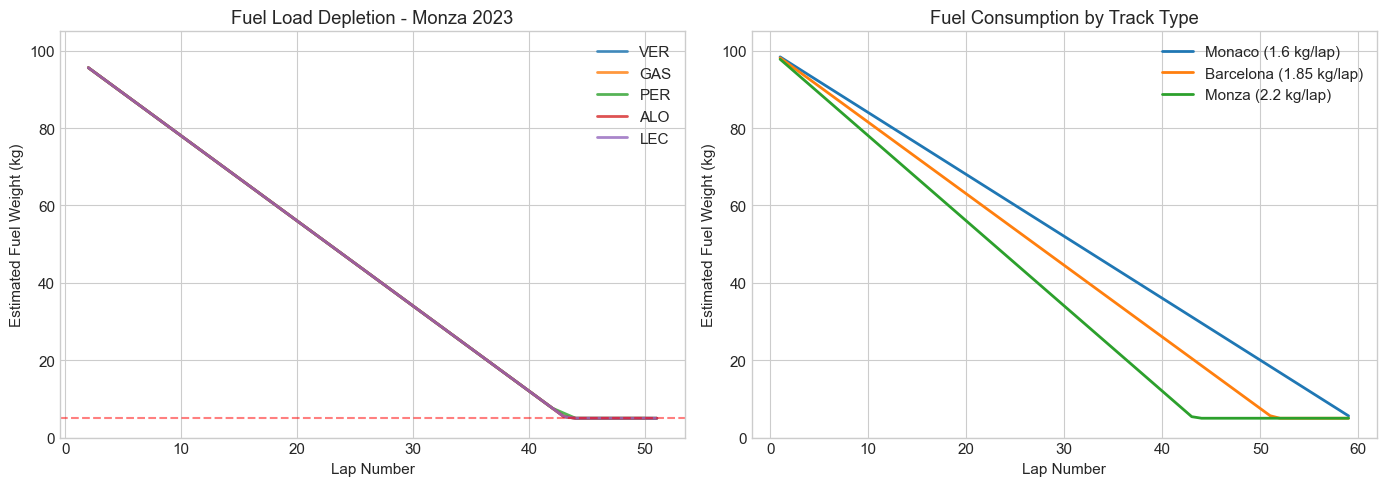

Saved: reports\fuel_load_demonstration.png


In [7]:
# Plot: Fuel Weight Over Race
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: All drivers fuel consumption
ax1 = axes[0]
for driver in race_df['Driver'].unique()[:5]:  # Top 5 drivers for clarity
    driver_data = race_df[race_df['Driver'] == driver].sort_values('LapNumber')
    ax1.plot(driver_data['LapNumber'], driver_data['EstimatedFuelWeight'], 
             label=driver, alpha=0.8, linewidth=2)

ax1.set_xlabel('Lap Number')
ax1.set_ylabel('Estimated Fuel Weight (kg)')
ax1.set_title(f'Fuel Load Depletion - {race_name}')
ax1.legend(loc='upper right')
ax1.set_ylim(0, 105)
ax1.axhline(y=5, color='red', linestyle='--', alpha=0.5, label='Min fuel')

# Right: Theoretical fuel curves for different tracks
ax2 = axes[1]
laps = np.arange(1, 60)
tracks = {'Monaco (1.6 kg/lap)': 1.6, 'Barcelona (1.85 kg/lap)': 1.85, 'Monza (2.2 kg/lap)': 2.2}
for track, rate in tracks.items():
    fuel = np.maximum(100 - laps * rate, 5)
    ax2.plot(laps, fuel, label=track, linewidth=2)

ax2.set_xlabel('Lap Number')
ax2.set_ylabel('Estimated Fuel Weight (kg)')
ax2.set_title('Fuel Consumption by Track Type')
ax2.legend()
ax2.set_ylim(0, 105)

plt.tight_layout()
plt.savefig(REPORTS_DIR / 'fuel_load_demonstration.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {REPORTS_DIR / 'fuel_load_demonstration.png'}")

---
## 4. Visualization: Tire Grip Degradation by Compound

Compares `EstimatedGrip` curves for SOFT, MEDIUM, and HARD compounds.

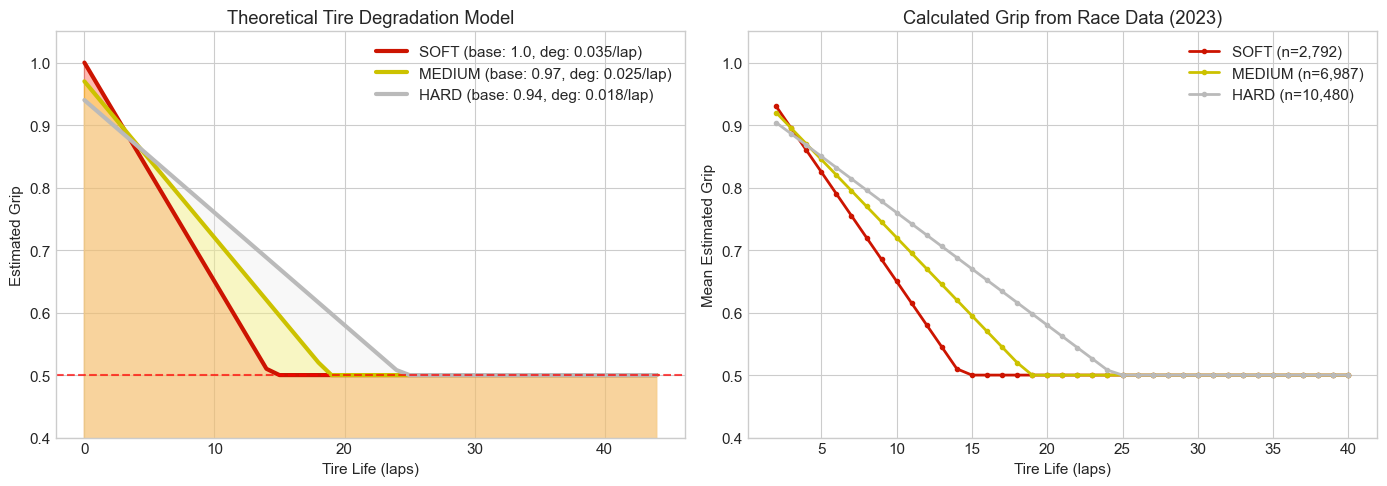

Saved: reports\tire_degradation_comparison.png


In [8]:
# Theoretical grip curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Theoretical model
ax1 = axes[0]
tire_life = np.arange(0, 45)
colors = {'SOFT': '#FF1801', 'MEDIUM': '#FFF200', 'HARD': '#EBEBEB'}
edge_colors = {'SOFT': '#CC1401', 'MEDIUM': '#CCC200', 'HARD': '#BABABA'}

for compound in ['SOFT', 'MEDIUM', 'HARD']:
    base_grip = TIRE_BASE_GRIP[compound]
    deg_rate = TIRE_DEGRADATION_RATE[compound]
    degradation = np.minimum(tire_life * deg_rate, 0.5)
    grip = np.maximum(base_grip - degradation, 0.5)
    ax1.plot(tire_life, grip, label=f"{compound} (base: {base_grip}, deg: {deg_rate}/lap)",
             color=edge_colors[compound], linewidth=3)
    ax1.fill_between(tire_life, grip, alpha=0.3, color=colors[compound])

ax1.set_xlabel('Tire Life (laps)')
ax1.set_ylabel('Estimated Grip')
ax1.set_title('Theoretical Tire Degradation Model')
ax1.legend()
ax1.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='Cliff point')
ax1.set_ylim(0.4, 1.05)

# Right: Actual data from races
ax2 = axes[1]
for compound in ['SOFT', 'MEDIUM', 'HARD']:
    compound_data = physics_df[physics_df['Compound'].str.upper() == compound]
    if len(compound_data) > 0:
        # Group by TyreLife and get mean grip
        grip_by_life = compound_data.groupby('TyreLife')['EstimatedGrip'].mean()
        # Only plot up to 40 laps for clarity
        grip_by_life = grip_by_life[grip_by_life.index <= 40]
        ax2.plot(grip_by_life.index, grip_by_life.values, 
                 label=f"{compound} (n={len(compound_data):,})",
                 color=edge_colors[compound], linewidth=2, marker='o', markersize=3)

ax2.set_xlabel('Tire Life (laps)')
ax2.set_ylabel('Mean Estimated Grip')
ax2.set_title('Calculated Grip from Race Data (2023)')
ax2.legend()
ax2.set_ylim(0.4, 1.05)

plt.tight_layout()
plt.savefig(REPORTS_DIR / 'tire_degradation_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {REPORTS_DIR / 'tire_degradation_comparison.png'}")

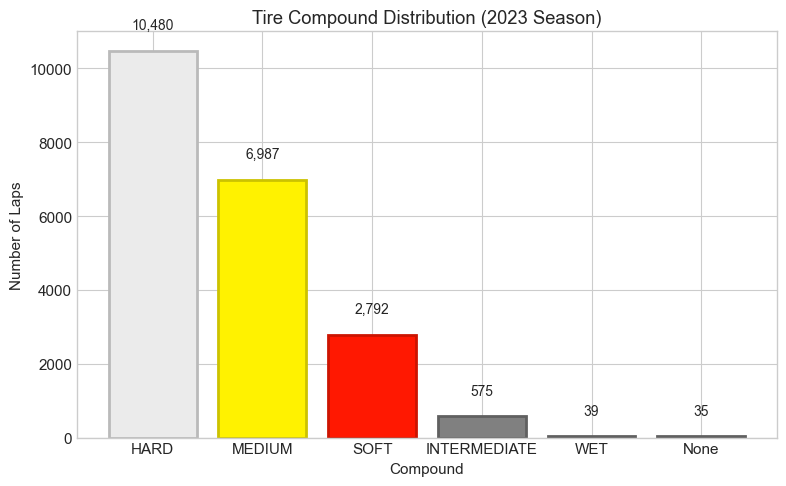

In [9]:
# Distribution of tire compounds in the data
fig, ax = plt.subplots(figsize=(8, 5))
compound_counts = physics_df['Compound'].value_counts()
colors_list = [colors.get(c.upper(), '#808080') for c in compound_counts.index]
edge_list = [edge_colors.get(c.upper(), '#606060') for c in compound_counts.index]

bars = ax.bar(compound_counts.index, compound_counts.values, color=colors_list, edgecolor=edge_list, linewidth=2)
ax.set_xlabel('Compound')
ax.set_ylabel('Number of Laps')
ax.set_title('Tire Compound Distribution (2023 Season)')

for bar, count in zip(bars, compound_counts.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 500, 
            f'{count:,}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig(REPORTS_DIR / 'compound_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 5. Correlation Matrix: Physics Features vs Lap Time

Shows how strongly the new physics features correlate with actual lap times.

In [10]:
# Add LapTimeSeconds if not present
if 'LapTimeSeconds' not in physics_df.columns:
    physics_df['LapTimeSeconds'] = physics_df['LapTime'].dt.total_seconds()

# Select numeric features for correlation
correlation_features = [
    'LapTimeSeconds',
    # Physics features
    'EstimatedFuelWeight',
    'FuelEffect',
    'TireDegradation',
    'EstimatedGrip',
    'SessionProgress',
    'TrackEvolution',
    # Original features
    'LapNumber',
    'TyreLife',
    'Stint',
]

# Add weather if available
for col in ['AirTemp', 'TrackTemp', 'TempGripEffect']:
    if col in physics_df.columns and physics_df[col].notna().any():
        correlation_features.append(col)

# Filter to available columns
available_features = [f for f in correlation_features if f in physics_df.columns]
corr_df = physics_df[available_features].dropna()

print(f"Samples for correlation analysis: {len(corr_df):,}")
print(f"Features: {len(available_features)}")

Samples for correlation analysis: 20,873
Features: 10


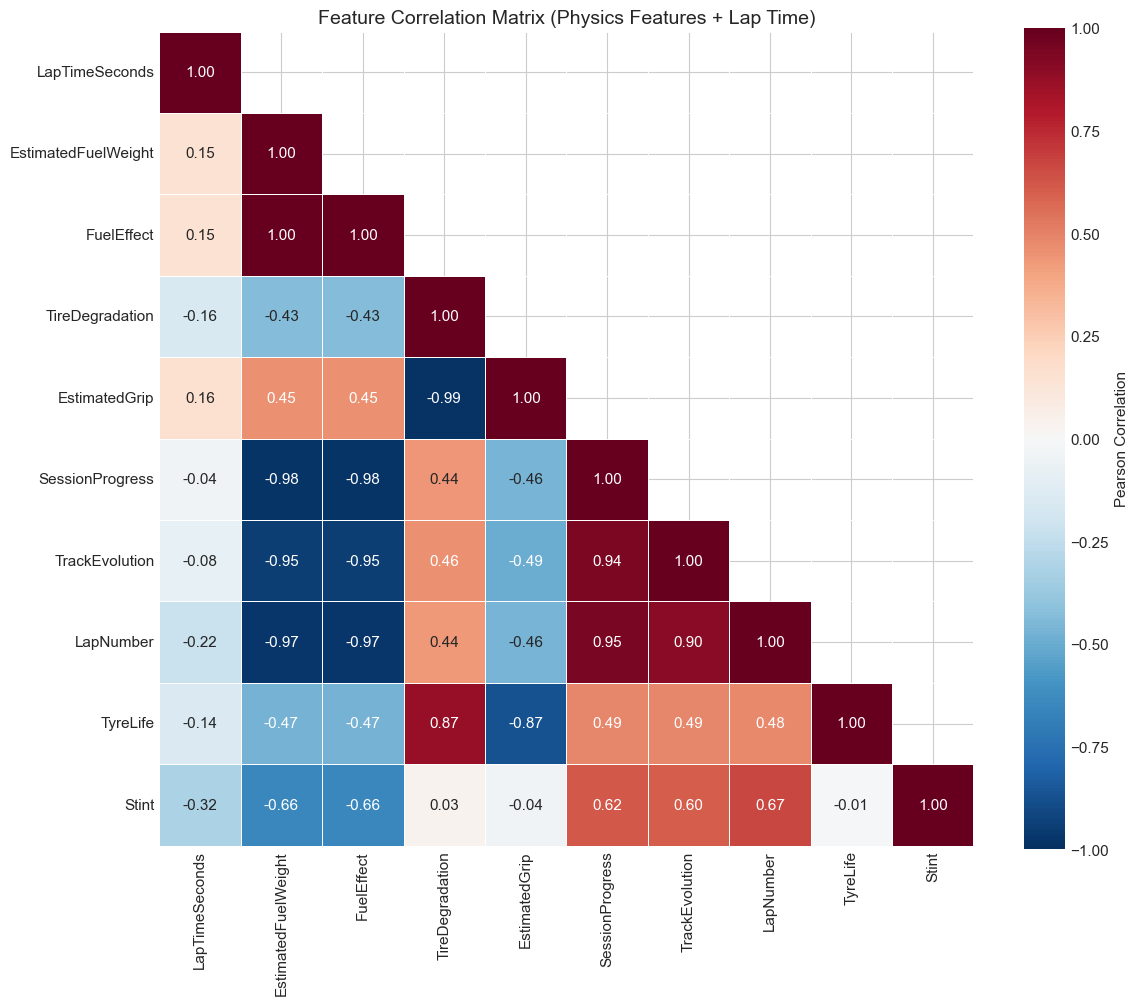

Saved: reports\physics_features_correlation_matrix.png


In [11]:
# Calculate correlation matrix
corr_matrix = corr_df.corr()

# Plot full correlation matrix
fig, ax = plt.subplots(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)

sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r',
            center=0, vmin=-1, vmax=1, square=True, linewidths=0.5,
            cbar_kws={'label': 'Pearson Correlation'}, ax=ax)

ax.set_title('Feature Correlation Matrix (Physics Features + Lap Time)', fontsize=14)
plt.tight_layout()
plt.savefig(REPORTS_DIR / 'physics_features_correlation_matrix.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {REPORTS_DIR / 'physics_features_correlation_matrix.png'}")

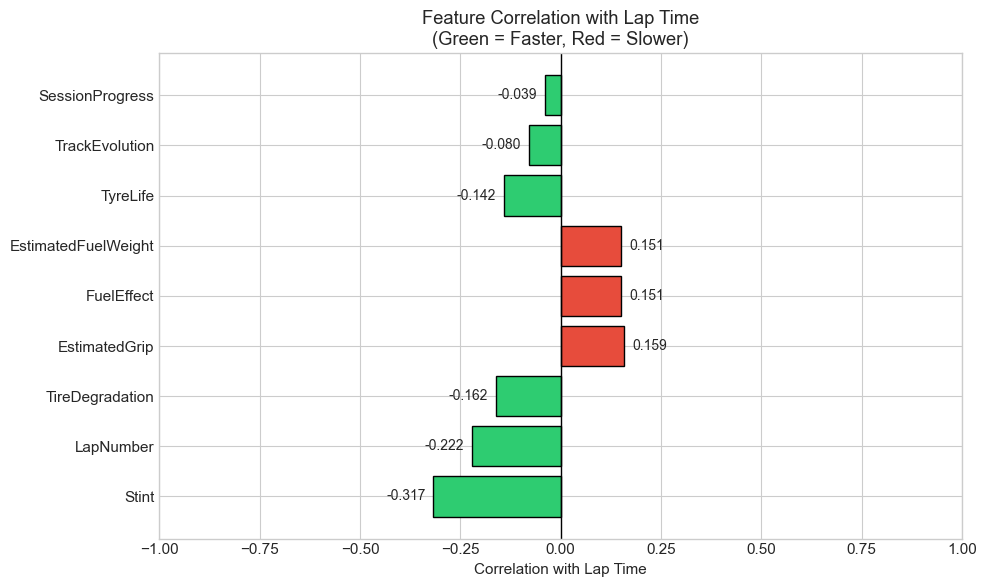

Saved: reports\laptime_correlation_ranking.png


In [12]:
# Focus: Correlation with LapTimeSeconds
lap_time_corr = corr_matrix['LapTimeSeconds'].drop('LapTimeSeconds').sort_values(key=abs, ascending=False)

fig, ax = plt.subplots(figsize=(10, 6))
colors_bar = ['#2ecc71' if c < 0 else '#e74c3c' for c in lap_time_corr.values]
bars = ax.barh(lap_time_corr.index, lap_time_corr.values, color=colors_bar, edgecolor='black')
ax.axvline(x=0, color='black', linewidth=1)
ax.set_xlabel('Correlation with Lap Time')
ax.set_title('Feature Correlation with Lap Time\n(Green = Faster, Red = Slower)')
ax.set_xlim(-1, 1)

# Add value labels
for bar, val in zip(bars, lap_time_corr.values):
    x_pos = val + 0.02 if val >= 0 else val - 0.02
    ha = 'left' if val >= 0 else 'right'
    ax.text(x_pos, bar.get_y() + bar.get_height()/2, f'{val:.3f}', 
            va='center', ha=ha, fontsize=10)

plt.tight_layout()
plt.savefig(REPORTS_DIR / 'laptime_correlation_ranking.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {REPORTS_DIR / 'laptime_correlation_ranking.png'}")

In [13]:
# Summary table
print("\n" + "="*60)
print("PHYSICS FEATURE CORRELATION SUMMARY")
print("="*60)
print(f"{'Feature':<25} {'Correlation':>12} {'Interpretation'}")
print("-"*60)
for feat, corr_val in lap_time_corr.items():
    interpretation = "Slower" if corr_val > 0 else "Faster"
    strength = "Strong" if abs(corr_val) > 0.3 else "Moderate" if abs(corr_val) > 0.1 else "Weak"
    print(f"{feat:<25} {corr_val:>12.4f} {strength} {interpretation}")
print("="*60)


PHYSICS FEATURE CORRELATION SUMMARY
Feature                    Correlation Interpretation
------------------------------------------------------------
Stint                          -0.3172 Strong Faster
LapNumber                      -0.2223 Moderate Faster
TireDegradation                -0.1623 Moderate Faster
EstimatedGrip                   0.1587 Moderate Slower
FuelEffect                      0.1510 Moderate Slower
EstimatedFuelWeight             0.1510 Moderate Slower
TyreLife                       -0.1421 Moderate Faster
TrackEvolution                 -0.0803 Weak Faster
SessionProgress                -0.0393 Weak Faster


---
## 6. Feature Matrix Summary

Build the complete feature table and show statistics.

In [14]:
# Build full feature table
feature_df, numeric_cols, categorical_cols = build_feature_table(
    clean_df, include_physics=True, verbose=True
)


PHYSICS-BASED FEATURE ENGINEERING

Fuel consumption rates applied for 22 circuits:
  - Sakhir: 2.0 kg/lap
  - Jeddah: 2.1 kg/lap
  - Melbourne: 1.85 kg/lap
  - Baku: 2.0 kg/lap
  - Miami: 1.85 kg/lap
  ... and 17 more circuits

Tire degradation model applied:
  - HARD: 10,480 laps (base grip: 0.94, deg rate: 0.018/lap)
  - MEDIUM: 6,987 laps (base grip: 0.97, deg rate: 0.025/lap)
  - SOFT: 2,792 laps (base grip: 1.0, deg rate: 0.035/lap)
  - INTERMEDIATE: 575 laps (base grip: 0.92, deg rate: 0.02/lap)
  - WET: 39 laps (base grip: 0.88, deg rate: 0.015/lap)

Track evolution features added:
  - SessionProgress: LapNumber / TotalLaps (0.0 to 1.0)
  - TrackEvolution: log-scaled track rubber-in effect
  - Weather features: None available in data


FEATURE MATRIX SUMMARY
Total samples: 20,908

Numeric features (13):
  - LapNumber: 20,908 non-null values
  - Stint: 20,908 non-null values
  - TyreLife: 20,873 non-null values
  - LapTimeLag1: 20,482 non-null values
  - LapTimeLag2: 20,057 non-

In [15]:
# Show sample of feature matrix
print("Feature Matrix Sample:")
display_cols = ['Driver', 'Circuit', 'LapNumber', 'Compound', 'TyreLife',
                'EstimatedFuelWeight', 'EstimatedGrip', 'SessionProgress', 'LapTimeSeconds']
available_display = [c for c in display_cols if c in feature_df.columns]
feature_df[available_display].head(10)

Feature Matrix Sample:


,Driver,Circuit,LapNumber,Compound,TyreLife,EstimatedFuelWeight,EstimatedGrip,SessionProgress,LapTimeSeconds
0,ALB,Sakhir,2.0,SOFT,2.0,96.0,0.930,0.035088,100.430
1,ALB,Sakhir,3.0,SOFT,3.0,94.0,0.895,0.052632,100.143
2,ALB,Sakhir,4.0,SOFT,4.0,92.0,0.860,0.070175,99.761
3,ALB,Sakhir,5.0,SOFT,5.0,90.0,0.825,0.087719,100.606
4,ALB,Sakhir,6.0,SOFT,6.0,88.0,0.790,0.105263,100.744
5,ALB,Sakhir,7.0,SOFT,7.0,86.0,0.755,0.122807,100.646
6,ALB,Sakhir,8.0,SOFT,8.0,84.0,0.720,0.140351,100.918
7,ALB,Sakhir,9.0,SOFT,9.0,82.0,0.685,0.157895,100.969
8,ALB,Sakhir,10.0,SOFT,10.0,80.0,0.650,0.175439,101.119
9,ALB,Sakhir,13.0,SOFT,2.0,74.0,0.930,0.228070,98.649


In [16]:
# Statistics summary
print("\nNumeric Feature Statistics:")
stats_cols = [c for c in numeric_cols if c in feature_df.columns]
feature_df[stats_cols].describe().round(3)


Numeric Feature Statistics:


,LapNumber,Stint,TyreLife,LapTimeLag1,LapTimeLag2,LapTimeLag3,RollingMean3,EstimatedFuelWeight,FuelEffect,TireDegradation,EstimatedGrip,SessionProgress,TrackEvolution
count,20908.000,20908.000,20873.000,20482.000,20057.000,19632.000,20482.000,20908.000,20908.000,20908.000,20908.000,20908.000,20908.000
mean,32.029,2.280,15.024,89.011,88.994,88.976,89.084,42.742,0.427,0.296,0.670,0.522,0.796
std,18.132,1.044,9.826,10.863,10.871,10.879,10.801,29.641,0.296,0.152,0.139,0.282,0.176
min,2.000,1.000,2.000,68.111,68.111,68.111,68.242,5.000,0.050,0.000,0.500,0.026,0.251
25%,17.000,1.000,7.000,79.705,79.629,79.567,79.826,13.600,0.136,0.162,0.508,0.282,0.700
50%,31.000,2.000,13.000,87.652,87.622,87.590,87.772,40.800,0.408,0.288,0.670,0.521,0.846
75%,46.000,3.000,20.000,97.880,97.882,97.890,97.964,68.500,0.685,0.450,0.795,0.771,0.937
max,78.000,8.000,58.000,148.490,148.490,148.490,132.670,96.800,0.968,0.500,0.970,1.000,1.000


---
## 7. Conclusion

### Physics Features Summary

| Feature | Description | Expected Impact |
|---------|-------------|----------------|
| `EstimatedFuelWeight` | Remaining fuel in kg | Lighter = Faster |
| `FuelEffect` | Normalized fuel (0-1) | Higher = Slower |
| `TireDegradation` | Cumulative grip loss | Higher = Slower |
| `EstimatedGrip` | Remaining grip level | Higher = Faster |
| `SessionProgress` | Race completion ratio | Mixed (fuel vs track) |
| `TrackEvolution` | Track rubber-in effect | Higher = Faster |

### Key Findings
- Fuel weight correlates positively with lap time (more fuel = slower)
- Tire degradation shows expected compound differences
- Track evolution captures the "rubbering in" effect

### Ready for Phase 3: Model Training
The physics features are validated and ready for model integration.

In [17]:
# List saved plots
print("\nSaved Plots in reports/:")
for plot_file in REPORTS_DIR.glob('*.png'):
    print(f"  - {plot_file.name}")


Saved Plots in reports/:
  - compound_distribution.png
  - feature_importance_xgboost_top10.png
  - fuel_load_demonstration.png
  - laptime_correlation_ranking.png
  - physics_features_correlation_matrix.png
  - spa_2023_pred_vs_actual.png
  - tire_degradation_comparison.png
